Model classifies messages to toxic and not toxic messages.

Dataset sources:


*   https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset?select=FinalBalancedDataset.csv
*   https://www.kaggle.com/datasets/akashsuper2000/toxic-comment-classification?select=validation.csv



# Imports

In [1]:
import os
import seaborn
import re
import string
import spacy
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix,recall_score,f1_score,precision_score
from sklearn.preprocessing import LabelBinarizer
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

# Constants

In [13]:
toxic_messages_directory = '/content/gdrive/MyDrive/BasementFriends/toxicMessages'
dataset_to_prepare_directory_name = 'dataset_to_prepare'
dataset1_file_name = 'validation.csv'
dataset2_file_name = 'test.csv'
dataset3_file_name = 'train.csv'
dataset4_file_name = 'FinalBalancedDataset.csv'
full_dataset_file_name = 'toxic_messages_full_dataset.csv'
best_classifier_file_name = 'best_classifier.pkl'
tokenizer_file_name = 'tokenizer.pkl'

# Mounting with Google Drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Creating full dataset from downloaded datasets

## First dataset

In [4]:
dataset1_full_path = os.path.join(os.path.join(toxic_messages_directory, dataset_to_prepare_directory_name), dataset1_file_name)
dataset1 = pd.read_csv(dataset1_full_path, header=0)
dataset1 = dataset1.rename(columns={'comment_text':'message', 'toxic':'is_toxic'})
print(dataset1.shape)
dataset1.head()

(20000, 2)


,message,is_toxic
0,I presume you know that your statement is idio...,1
1,"Hey, pothead, you think you're tough,\npick up...",1
2,Rich niggaaaazzz \n\nYour a nigger 66.35.55.23,1
3,"RD sez ""I support these people. They are as ho...",1
4,"No, this is on the RG, who switched over to th...",1


## Second dataset

In [5]:
dataset2_full_path = os.path.join(os.path.join(toxic_messages_directory, dataset_to_prepare_directory_name), dataset2_file_name)
dataset2 = pd.read_csv(dataset2_full_path, header=0)
dataset2 = dataset2.rename(columns={'comment_text':'message', 'toxic':'is_toxic'})
print(dataset2.shape)
dataset2.head()

(20000, 2)


,message,is_toxic
0,This letter perfectly illustrates why any hope...,1
1,One muslim casualty vs the hundreds and thousa...,1
2,(fuck you Osama bin laden and your afghanistan...,1
3,As long as Trump keeps Stiggin' It to the libs...,1
4,This article is a load of crap.... Another Fa...,1


## Third dataset

In [6]:
dataset3_full_path = os.path.join(os.path.join(toxic_messages_directory, dataset_to_prepare_directory_name), dataset3_file_name)
dataset3 = pd.read_csv(dataset3_full_path, header=0)
dataset3 = dataset3.rename(columns={'comment_text':'message', 'toxic':'is_toxic'})
print(dataset3.shape)
dataset3.head()

(120000, 2)


,message,is_toxic
0,"Wasn't me, asshole. Check your fucking IP's b...",1
1,Stupid law. Why does Quebec always have to ca...,1
2,after qualifying for the Wimbledon main draw -...,1
3,THE QUESTION IS NOT WHETHER IT'S ART OR PORNOG...,1
4,fuck you white trash!!!,1


## Fourth dataset

In [7]:
dataset4_full_path = os.path.join(os.path.join(toxic_messages_directory, dataset_to_prepare_directory_name), dataset4_file_name)
dataset4 = pd.read_csv(dataset4_full_path, header=0)
dataset4.head()

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [8]:
dataset4 = dataset4[['tweet', 'Toxicity']]
dataset4 = dataset4.rename(columns={'tweet':'message', 'Toxicity':'is_toxic'})
print(dataset4.shape)
dataset4.head()

(56745, 2)


,message,is_toxic
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


## Creating full dataset from above datasets

In [9]:
full_dataset = pd.DataFrame(columns=['message', 'is_toxic'])
full_dataset = pd.concat([dataset1, dataset2, dataset3, dataset4], ignore_index=True)
print(full_dataset.shape)
full_dataset.head()

(216745, 2)


,message,is_toxic
0,I presume you know that your statement is idio...,1
1,"Hey, pothead, you think you're tough,\npick up...",1
2,Rich niggaaaazzz \n\nYour a nigger 66.35.55.23,1
3,"RD sez ""I support these people. They are as ho...",1
4,"No, this is on the RG, who switched over to th...",1


# Inspecting and preparing the dataset

## Removing duplicates:

In [10]:
full_dataset.drop_duplicates()
print(full_dataset.shape)

(216745, 2)


## Inspecting the data

In [ ]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216745 entries, 0 to 216744
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   message   216745 non-null  object
 1   is_toxic  216745 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [ ]:
full_dataset.describe()

,is_toxic
count,216745.000000
mean,0.480532
std,0.499622
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
full_dataset.isna().sum()

message     0
is_toxic    0
dtype: int64

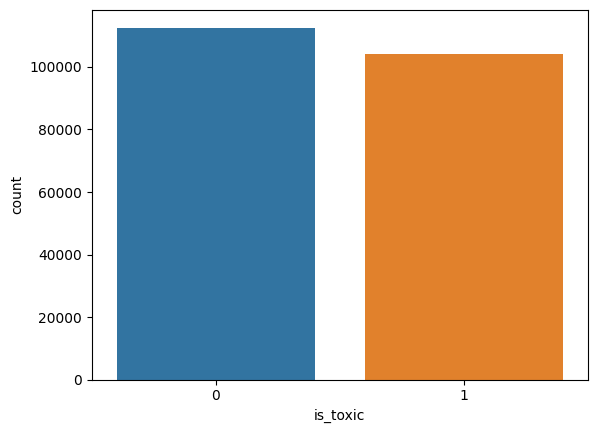

In [ ]:
seaborn.countplot(data = full_dataset, x = 'is_toxic')
plt.show()

## Preparing the data

In [14]:
def clean_message(message):
    message = message.lower()
    message = re.sub(r"what's", "what is ", message)
    message = re.sub(r"\'s", " ", message)
    message = re.sub(r"\'ve", " have ", message)
    message = re.sub(r"can't", "cannot ", message)
    message = re.sub(r"n't", " not ", message)
    message = re.sub(r"i'm", "i am ", message)
    message = re.sub(r"\'re", " are ", message)
    message = re.sub(r"\'d", " would ", message)
    message = re.sub(r"\'ll", " will ", message)
    message = re.sub(r"\'scuse", " excuse ", message)
    message = re.sub('\W', ' ', message)
    message = re.sub('\s+', ' ', message)
    message = re.sub(r'#[0-9]+|@[0-9a-zA-Z]+|#|https?://[0-9a-zA-Z\./\-_\?]+|â¦|(amp)|[^\x20-\x7e]|â|¥|ð|»|¼|ï|¸|¦|±|¯|[0-9]+', '', message)
    message = message.strip(' ')
    return message

full_dataset['message'] = full_dataset['message'].map(lambda message : clean_message(message))

In [15]:
def remove_punctuations_and_digits(text : str):
    to_remove = string.punctuation + string.digits
    cur_text = ''
    for i in range(len(text)):
        if text[i] in to_remove:
            cur_text += ' '
        else:
            cur_text += text[i]
    cur_text = ' '.join(cur_text.split())
    return cur_text

full_dataset['message'] = full_dataset['message'].apply(lambda message : remove_punctuations_and_digits(message))

In [16]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def remove_stop_words(text: str):
    filtered_sentence = []
    for word in text.split(' '):
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    return ' '.join(filtered_sentence)

full_dataset['message'] = full_dataset['message'].apply(lambda message : remove_stop_words(message))

In [17]:
def lemmatize(text : str):
    return ' '.join([token.lemma_ for token in nlp(text)])
full_dataset['message'] = full_dataset['message'].apply(lambda message : lemmatize(message))

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_dataset['message'])
X = tokenizer.texts_to_sequences(full_dataset['message'])
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(full_dataset['message'][0]))
print("\nAfter tokenizing :\n{}".format(X[0]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[0]))

Vocabulary size: 174091

Example:

Sentence:
presume know statement idiotic feel sorry

After tokenizing :
[3600, 9, 207, 783, 86, 180]

After padding :
[3600    9  207 ...    0    0    0]


## Saving tokenizer

In [20]:
path = os.path.join(toxic_messages_directory, tokenizer_file_name)
with open(path, 'wb') as pickle_file:
    pickle.dump(tokenizer, pickle_file)

# Preparing testing, validation and training sets

In [38]:
train_samples, val_samples, train_labels, val_labels = train_test_split(X, full_dataset['is_toxic'], test_size = 0.3, random_state = 20, shuffle=True)
val_samples, test_samples, val_labels, test_labels = train_test_split(val_samples, val_labels, test_size = 0.3, random_state = 20, shuffle=True)

In [40]:
print(train_samples.shape)

(151721, 1963)


In [ ]:
print('Train:\n')
print(train_samples.shape)
print(train_labels.shape)

print('\nVal:\n')
print(val_samples.shape)
print(val_labels.shape)

print('\nTest:\n')
print(test_samples.shape)
print(test_labels.shape)

Train:

(151721, 1963)
(151721,)

Val:

(45516, 1963)
(45516,)

Test:

(19508, 1963)
(19508,)


## Label Binarizer

In [ ]:
lb = LabelBinarizer()
train_labels_binarized = lb.fit_transform(train_labels)
train_labels_binarized = train_labels.astype(float)
train_labels_binarized = tf.keras.utils.to_categorical(train_labels_binarized)

val_labels_binarized = lb.transform(val_labels)
val_labels_binarized = val_labels.astype(float)
val_labels_binarized = tf.keras.utils.to_categorical(val_labels_binarized)

test_labels_binarized = lb.transform(test_labels)
test_labels_binarized = test_labels.astype(float)
test_labels_binarized = tf.keras.utils.to_categorical(test_labels_binarized)

In [ ]:
print(train_labels_binarized)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


# Choosing most promising models

## Decision Tree Classifier

In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_samples, train_labels_binarized)
decision_tree_predictions = decision_tree.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, decision_tree_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), decision_tree_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), decision_tree_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), decision_tree_predictions.argmax(axis=1))))

Accuracy: 0.6952500219702962

Confusion matrix:
[[16645  6986]
 [ 6879 15006]]

Classification report:               precision    recall  f1-score   support

           0       0.71      0.70      0.71     23631
           1       0.68      0.69      0.68     21885

    accuracy                           0.70     45516
   macro avg       0.69      0.70      0.69     45516
weighted avg       0.70      0.70      0.70     45516


Cohen's Kappa: 0.3899760584781927


## Random Forest Classifier

In [ ]:
random_forest = RandomForestClassifier(n_estimators=50, oob_score=True, n_jobs=-1)
random_forest.fit(train_samples, train_labels_binarized)
random_forest_predictions = random_forest.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, random_forest_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), random_forest_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), random_forest_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), random_forest_predictions.argmax(axis=1))))

Accuracy: 0.7254372088935759

Confusion matrix:
[[17326  6305]
 [ 5511 16374]]

Classification report:               precision    recall  f1-score   support

           0       0.76      0.73      0.75     23631
           1       0.72      0.75      0.73     21885

    accuracy                           0.74     45516
   macro avg       0.74      0.74      0.74     45516
weighted avg       0.74      0.74      0.74     45516


Cohen's Kappa: 0.4807288151070612


## SGD Classifier

In [ ]:
sgd = SGDClassifier(early_stopping=True, warm_start=True)
sgd.fit(train_samples, train_labels)
sgd_predictions = sgd.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels, sgd_predictions)))

Accuracy: 0.5354380877054222



## Naive Bayes

In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(train_samples, train_labels)
naive_bayes_predictions = naive_bayes.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels, naive_bayes_predictions)))

Accuracy: 0.5195096229897179



## SVC

In [ ]:
svc = SVC(max_iter=50)
svc.fit(train_samples, train_labels)
svc_predictions = svc.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels, svc_predictions)))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.5523332454521487



## XGBoost Classifier

In [ ]:
xgboost = XGBClassifier()
xgboost.fit(train_samples, train_labels_binarized)
xgboost_predictions = xgboost.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, xgboost_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))

Accuracy: 0.7711793654978469

Confusion matrix:
[[16913  6718]
 [ 3697 18188]]

Classification report:               precision    recall  f1-score   support

           0       0.82      0.72      0.76     23631
           1       0.73      0.83      0.78     21885

    accuracy                           0.77     45516
   macro avg       0.78      0.77      0.77     45516
weighted avg       0.78      0.77      0.77     45516


Cohen's Kappa: 0.5440096887088695


## Nearest Neighbors Classifier

In [ ]:
nearest_neighbors = KNeighborsClassifier(n_neighbors=5)
nearest_neighbors.fit(train_samples, train_labels_binarized)
nearest_neighbors_predictions = nearest_neighbors.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, nearest_neighbors_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), nearest_neighbors_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), nearest_neighbors_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), nearest_neighbors_predictions.argmax(axis=1))))

Accuracy: 0.6198919061428948

Confusion matrix:
[[14487  9144]
 [ 8157 13728]]

Classification report:               precision    recall  f1-score   support

           0       0.64      0.61      0.63     23631
           1       0.60      0.63      0.61     21885

    accuracy                           0.62     45516
   macro avg       0.62      0.62      0.62     45516
weighted avg       0.62      0.62      0.62     45516


Cohen's Kappa: 0.23992986330035893


In [ ]:
three_nearest_neighbors = KNeighborsClassifier(n_neighbors=3)
three_nearest_neighbors.fit(train_samples, train_labels_binarized)
three_nearest_neighbors_predictions = three_nearest_neighbors.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, three_nearest_neighbors_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), three_nearest_neighbors_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), three_nearest_neighbors_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), three_nearest_neighbors_predictions.argmax(axis=1))))

Accuracy: 0.6183979260040425

Confusion matrix:
[[14582  9049]
 [ 8320 13565]]

Classification report:               precision    recall  f1-score   support

           0       0.64      0.62      0.63     23631
           1       0.60      0.62      0.61     21885

    accuracy                           0.62     45516
   macro avg       0.62      0.62      0.62     45516
weighted avg       0.62      0.62      0.62     45516


Cohen's Kappa: 0.23661056084936694


# Regularization

Most promising classifiers are XGBoost Classifier, Random Forest Classifier and Desicion Tree Classifier.

Now it's time to find best hiperparameters, so the models will predict better.

### Regularization of XGBoost Classifier

I tried to run the code below, but there was not enough RAM memory:

In [ ]:
param_grid = [{'max_depth' : [2, 4, 6, 8, 10],
              'validate_parameters' : [False, True]}]

In [ ]:
reg_xgboost = XGBClassifier(n_jobs = -1)
grid_search = GridSearchCV(reg_xgboost, param_grid, cv = 5, scoring='accuracy', return_train_score=True)
grid_search.fit(train_samples, train_labels_binarized)
print('Best parameters:\n', grid_search.best_params_)
print('\nBest estimator:\n', grid_search.best_estimator_)

I decided to run some experiments and choose the best model.

In [ ]:
xgboost = XGBClassifier(max_depth=8, validate_parameters=False)
xgboost.fit(train_samples, train_labels_binarized)
xgboost_predictions = xgboost.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, xgboost_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))

Accuracy: 0.7847350382283154

Confusion matrix:
[[17763  5868]
 [ 3930 17955]]

Classification report:               precision    recall  f1-score   support

           0       0.82      0.75      0.78     23631
           1       0.75      0.82      0.79     21885

    accuracy                           0.78     45516
   macro avg       0.79      0.79      0.78     45516
weighted avg       0.79      0.78      0.78     45516


Cohen's Kappa: 0.5702415483204619


In [ ]:
xgboost = XGBClassifier(max_depth=10, validate_parameters=False)
xgboost.fit(train_samples, train_labels_binarized)
xgboost_predictions = xgboost.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, xgboost_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))

Accuracy: 0.7869540381404342

Confusion matrix:
[[17891  5740]
 [ 3957 17928]]

Classification report:               precision    recall  f1-score   support

           0       0.82      0.76      0.79     23631
           1       0.76      0.82      0.79     21885

    accuracy                           0.79     45516
   macro avg       0.79      0.79      0.79     45516
weighted avg       0.79      0.79      0.79     45516


Cohen's Kappa: 0.5745606432887118


In [ ]:
xgboost = XGBClassifier(max_depth=10, validate_parameters=True)
xgboost.fit(train_samples, train_labels_binarized)
xgboost_predictions = xgboost.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, xgboost_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), xgboost_predictions.argmax(axis=1))))

Accuracy: 0.7869540381404342

Confusion matrix:
[[17891  5740]
 [ 3957 17928]]

Classification report:               precision    recall  f1-score   support

           0       0.82      0.76      0.79     23631
           1       0.76      0.82      0.79     21885

    accuracy                           0.79     45516
   macro avg       0.79      0.79      0.79     45516
weighted avg       0.79      0.79      0.79     45516


Cohen's Kappa: 0.5745606432887118


Metrics are same for models which have validate_parameters hiperparameter set to True or False, so I decided to use model with validate_parameters=False because it's faster.

### Regularization of Random Forest Classifier



In [ ]:
param_grid = [{
              'max_depth' : [10, 50, 100],
              'bootstrap' : [False, True]
               }]

In [ ]:
reg_random_forest = RandomForestClassifier(n_estimators=50, n_jobs = -1)
grid_search = GridSearchCV(reg_random_forest, param_grid, cv = 5, scoring='accuracy', return_train_score=True)
grid_search.fit(train_samples, train_labels_binarized)
print('Best parameters:\n', grid_search.best_params_)
print('\nBest estimator:\n', grid_search.best_estimator_)

Best parameters:
 {'bootstrap': False, 'max_depth': 50}

Best estimator:
 RandomForestClassifier(bootstrap=False, max_depth=50, n_estimators=50,
                       n_jobs=-1)


In [ ]:
best_random_forest = RandomForestClassifier(bootstrap=False, max_features = 500, n_estimators = 500, max_depth=50)
best_random_forest.fit(train_samples, train_labels_binarized)
best_random_forest_predictions = best_random_forest.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, best_random_forest_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), best_random_forest_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), best_random_forest_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), best_random_forest_predictions.argmax(axis=1))))

Accuracy: 0.7635556727304684

Confusion matrix:
[[15879  7752]
 [ 3010 18875]]

Classification report:               precision    recall  f1-score   support

           0       0.84      0.67      0.75     23631
           1       0.71      0.86      0.78     21885

    accuracy                           0.76     45516
   macro avg       0.77      0.77      0.76     45516
weighted avg       0.78      0.76      0.76     45516


Cohen's Kappa: 0.530175288190321


### Regularization of Decision Tree Classifier

In [ ]:
param_grid = [{
              'max_depth' : [10, 50, 100],
              'splitter' : ['best', 'random'],
              'min_samples_split' : [2, 5, 10]
               }]

In [ ]:
reg_decision_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(reg_decision_tree, param_grid, cv = 5, scoring='accuracy', return_train_score=True)
grid_search.fit(train_samples, train_labels_binarized)
print('Best parameters:\n', grid_search.best_params_)
print('\nBest estimator:\n', grid_search.best_estimator_)

Best parameters:
 {'max_depth': 50, 'min_samples_split': 2, 'splitter': 'best'}

Best estimator:
 DecisionTreeClassifier(max_depth=50)


In [ ]:
best_decision_tree = DecisionTreeClassifier(max_depth=50)
best_decision_tree.fit(train_samples, train_labels_binarized)
best_decision_tree_predictions = best_decision_tree.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, best_decision_tree_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), best_decision_tree_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), best_decision_tree_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), best_decision_tree_predictions.argmax(axis=1))))

Accuracy: 0.7076192987081465

Confusion matrix:
[[14589  9042]
 [ 4232 17653]]

Classification report:               precision    recall  f1-score   support

           0       0.78      0.62      0.69     23631
           1       0.66      0.81      0.73     21885

    accuracy                           0.71     45516
   macro avg       0.72      0.71      0.71     45516
weighted avg       0.72      0.71      0.71     45516


Cohen's Kappa: 0.42057766925082307


## Voting Classifier

In [ ]:
rf = RandomForestClassifier(bootstrap=False, max_depth=50)
xgb = XGBClassifier(max_depth=10, validate_parameters=False)
dt = DecisionTreeClassifier(max_depth=50)

In [ ]:
vc = VotingClassifier(estimators=[('Random Forest', rf), ('XGBoost', xgb), ('Decision Tree', dt)], voting='hard')
voting_classifier = MultiOutputClassifier(vc, n_jobs=-1)
voting_classifier.fit(train_samples, train_labels_binarized)
voting_classifier_predictions = voting_classifier.predict(val_samples)
print('Accuracy: {}\n'.format(accuracy_score(val_labels_binarized, voting_classifier_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(val_labels_binarized.argmax(axis=1), voting_classifier_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(val_labels_binarized.argmax(axis=1), voting_classifier_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(val_labels_binarized.argmax(axis=1), voting_classifier_predictions.argmax(axis=1))))

Accuracy: 0.7610949995605941

Confusion matrix:
[[17021  6610]
 [ 3506 18379]]

Classification report:               precision    recall  f1-score   support

           0       0.83      0.72      0.77     23631
           1       0.74      0.84      0.78     21885

    accuracy                           0.78     45516
   macro avg       0.78      0.78      0.78     45516
weighted avg       0.78      0.78      0.78     45516


Cohen's Kappa: 0.5571622595555212


# Final performance of the best model

In [ ]:
final_predictions = voting_classifier.predict(test_samples)
print('Accuracy: {}\n'.format(accuracy_score(test_labels_binarized, final_predictions)))
print('Confusion matrix:\n{}\n'.format(confusion_matrix(test_labels_binarized.argmax(axis=1), final_predictions.argmax(axis=1))))
print('Classification report: {}\n'.format(classification_report(test_labels_binarized.argmax(axis=1), final_predictions.argmax(axis=1))))
print("Cohen's Kappa: {}".format(cohen_kappa_score(test_labels_binarized.argmax(axis=1), final_predictions.argmax(axis=1))))

Accuracy: 0.7620976009842116

Confusion matrix:
[[7350 2836]
 [1466 7856]]

Classification report:               precision    recall  f1-score   support

           0       0.83      0.72      0.77     10186
           1       0.73      0.84      0.79      9322

    accuracy                           0.78     19508
   macro avg       0.78      0.78      0.78     19508
weighted avg       0.79      0.78      0.78     19508


Cohen's Kappa: 0.5608206968365683


# Saving best classifier

In [ ]:
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)

In [ ]:
path = os.path.join(toxic_messages_directory, best_classifier_file_name)
save_zipped_pickle(classifier, path)

# Loading classifier

In [24]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [25]:
path = os.path.join(toxic_messages_directory, best_classifier_file_name)
classifier = load_zipped_pickle(path)

# Predicting

In [91]:
def predict(message : str):
  message_df = pd.DataFrame(data=list([message]), columns =['message'])
  message_df['message'] = message_df['message'].map(lambda message : clean_message(message))
  message_df['message'] = message_df['message'].map(lambda message : remove_punctuations_and_digits(message))
  message_df['message'] = message_df['message'].map(lambda message : remove_stop_words(message))
  message_df['message'] = message_df['message'].map(lambda message : lemmatize(message))
  X = tokenizer.texts_to_sequences(message_df['message'])
  X = pad_sequences(X, padding='post', maxlen=1963)

  prediction = classifier.predict(X)
  if prediction[0][1] == 0.:
    return "Not toxic"
  else:
    return "Toxic"

In [96]:
predict("I love you <3")

'Not toxic'